<a href="https://colab.research.google.com/github/EnesAgirman/ArUco_Markers/blob/main/Camelyon17_Wilds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0 ▸ Install dependencies & check CUDA
!pip install --quiet wilds torch torchvision tqdm matplotlib

# Clone SAM (PyTorch) repo and make it importable as `from sam import SAMSGD`
!git clone --depth=1 https://github.com/moskomule/sam.pytorch /content/sam_pytorch

import sys, os, torch
sys.path.insert(0, "/content/sam_pytorch")  # so `import sam` works

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    torch.cuda.set_device(0)
else:
    print("⚠️  No GPU detected (Runtime ▸ Change runtime type ▸ GPU).")

from google.colab import drive
drive.mount('/content/drive')


fatal: destination path '/content/sam_pytorch' already exists and is not an empty directory.
CUDA available: True
Device: NVIDIA L4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Cell 1 ▸ Imports & global knobs
from contextlib import nullcontext
from collections import Counter
from itertools import islice
from math import ceil, log
import random, math, numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Data-loader knobs (safe defaults; tweak later)
BATCH      = 3072
WORKERS    = 0         # bump to 2/4 once stable
PIN_MEM    = True
PERSISTENT = False
PREFETCH   = 2


In [3]:
# Cell 2 ▸ Camelyon17: clean corrupted archive, ensure metadata, and build a safe subset

import os, glob, numpy as np, random
from collections import Counter
from torchvision import transforms
from torch.utils.data import Subset
from wilds import get_dataset

# -------- 1) Resolve dataset root --------
DATA_ROOT = "/content/data"  # parent folder that contains 'camelyon17_v1.0'
DS_DIR    = os.path.join(DATA_ROOT, "camelyon17_v1.0")
PATCH_DIR = os.path.join(DS_DIR, "patches")
TAR_PATH  = os.path.join(DS_DIR, "archive.tar.gz")

os.makedirs(DATA_ROOT, exist_ok=True)
print(f"DATA_ROOT = {DATA_ROOT}")

if not os.path.exists(PATCH_DIR):
    print(f"⚠️  Patches folder not found at: {PATCH_DIR}")
else:
    print(f"✓ Found patches at: {PATCH_DIR}")

# -------- 2) Remove corrupted tar (if present) so WILDS will re-download metadata --------
if os.path.exists(TAR_PATH):
    try:
        os.remove(TAR_PATH)
        print(f"🧹 Removed corrupted archive: {TAR_PATH}")
    except Exception as e:
        print(f"⚠️  Could not remove {TAR_PATH}: {e}")

# NOTE: We keep existing patches; only the tar (metadata) is re-fetched.

# -------- 3) Get dataset (this will re-download any missing metadata/splits) --------
dataset = get_dataset(
    "camelyon17",
    root_dir=DATA_ROOT,
    download=True  # safe: won't re-download images in patches/, only missing files
)

# -------- 4) Transforms (as before) --------
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_ds = dataset.get_subset("train", transform=transform)
val_ds   = dataset.get_subset("val",   transform=transform)
test_ds  = dataset.get_subset("test",  transform=transform)

# -------- 5) Build a subset that SKIPS missing files --------
# We only need a small fraction; we'll probe indices until we collect enough valid ones.
DATA_FRACTION = 0.1
SEED          = 42

random.seed(SEED)
np.random.seed(SEED)

total_train  = len(train_ds)
target_keep  = max(1, int(round(total_train * DATA_FRACTION)))

print(f"[data] Train size = {total_train}, target subset = {target_keep} examples")

# Shuffle candidate indices
all_idx = np.random.permutation(total_train)

keep_idx = []
missing_examples = 0

from PIL import UnidentifiedImageError

# Helper: check if an index is loadable without crashing the dataloader
def _is_loadable(i):
    try:
        _ = train_ds[i]   # triggers PIL open
        return True
    except (FileNotFoundError, UnidentifiedImageError) as e:
        return False

# Collect loadable indices
for i in all_idx:
    if _is_loadable(i):
        keep_idx.append(i)
        if len(keep_idx) >= target_keep:
            break
    else:
        missing_examples += 1

if len(keep_idx) < target_keep:
    print(f"⚠️  Only found {len(keep_idx)} loadable examples out of requested {target_keep}.")
    print("    Some patch files are missing. Training will continue with the available subset.")

train_subset = Subset(train_ds, keep_idx)

# -------- 6) Report class distribution on the kept subset --------
labels_all = train_ds.y_array.cpu().numpy().astype(int)
subset_labels = labels_all[keep_idx] if len(keep_idx) > 0 else np.array([], dtype=int)
print(f"[data] Using {len(keep_idx)}/{total_train} "
      f"({100*len(keep_idx)/max(1,total_train):.2f} %) examples – "
      f"class counts: {dict(Counter(subset_labels))}")
print(f"[data] Skipped examples due to missing/corrupted files: {missing_examples}")

# -------- 7) Tiny sanity check: try loading one kept sample --------
if len(keep_idx) > 0:
    try:
        _ = train_subset[0]
        print("✓ Sanity check passed: a kept sample opened successfully.")
    except Exception as e:
        print("✗ Unexpected error opening a kept sample:", e)
        print("  Consider fully redownloading patches (set DELETE_PATCHES=True and re-run).")


DATA_ROOT = /content/data
✓ Found patches at: /content/data/camelyon17_v1.0/patches
[data] Train size = 302436, target subset = 30244 examples
[data] Using 30244/302436 (10.00 %) examples – class counts: {np.int64(1): 15202, np.int64(0): 15042}
[data] Skipped examples due to missing/corrupted files: 0
✓ Sanity check passed: a kept sample opened successfully.


In [4]:
# Cell 3 ▸ CUDA prefetcher & loader builder
class CUDAPrefetcher:
    def __init__(self, loader, device, channels_last=True):
        self.loader, self.device = loader, device
        self.stream = torch.cuda.Stream(device) if device.type == "cuda" else None
        self.channels_last = channels_last and (device.type == "cuda")

    def __iter__(self):
        self.iter = iter(self.loader)
        if self.stream is not None: self._prefetch()
        return self

    def __next__(self):
        if self.stream is None:
            x, y, idx = next(self.iter)
            return x.to(self.device), y.to(self.device), idx
        torch.cuda.current_stream().wait_stream(self.stream)
        if self.next is None: raise StopIteration
        batch = self.next; self._prefetch(); return batch

    def _prefetch(self):
        try: x, y, idx = next(self.iter)
        except StopIteration: self.next=None; return
        with torch.cuda.stream(self.stream):
            x, y, idx = x.to(self.device, non_blocking=True), \
                        y.to(self.device, non_blocking=True), \
                        idx.to(self.device, non_blocking=True)
            if self.channels_last: x = x.contiguous(memory_format=torch.channels_last)
        self.next = (x, y, idx)

class IndexedDataset(Dataset):
    """Return (x, y, idx) so RS can index per-example losses."""
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)
    def __getitem__(self, i):
        x, y, _ = self.subset[i]
        return x, y, i   # idx = 0…len-1

def make_loader(subset, batch_size, shuffle, workers):
    kwargs = dict(dataset=IndexedDataset(subset),
                  batch_size=batch_size,
                  shuffle=shuffle,
                  num_workers=workers,
                  pin_memory=(PIN_MEM and workers>0))
    if workers:
        kwargs.update(persistent_workers=PERSISTENT, prefetch_factor=PREFETCH)
    return DataLoader(**kwargs)

train_loader = make_loader(train_subset, BATCH, True,  WORKERS)
rs_loader    = make_loader(train_subset, BATCH, False, WORKERS)
val_loader   = get_eval_loader("standard", val_ds,  batch_size=BATCH)
test_loader  = get_eval_loader("standard", test_ds, batch_size=BATCH)
print("[data] loaders ready ✓")


[data] loaders ready ✓


In [5]:
# Cell 4 ▸ SimpleCNN (tiny, fast)
'''class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # 96 → 96
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 48 → 48
        self.pool  = nn.MaxPool2d(2)                  # /2 each time
        self.fc1   = nn.Linear(32*24*24, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))           # 96 → 48
        x = self.pool(F.relu(self.conv2(x)))           # 48 → 24
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Cell 4 ▸ ResNet-18 (random init, drop-in replacement for SimpleCNN)
import torch.nn as nn
from torchvision import models

class SimpleCNN(nn.Module):
    """Randomly initialized ResNet-18 with 2-class head; keeps .fc2 for init_bias()."""
    def __init__(self, num_classes=2):
        super().__init__()
        backbone = models.resnet18(weights=None)  # no pretraining
        in_feats = backbone.fc.in_features
        backbone.fc = nn.Linear(in_feats, num_classes)  # new classifier head
        self.backbone = backbone
        self.fc2 = self.backbone.fc  # keep name for init_bias compatibility

    def forward(self, x):
        return self.backbone(x)
        '''


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, in_shape=(3, 96, 96)):
        super().__init__()
        C, H, W = in_shape
        self.classifier = nn.Linear(C * H * W, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # (B, C*H*W)
        return self.classifier(x)  # logits for CrossEntropyLoss



In [6]:
# ─── Cell 4: Train & Eval Helpers ─────────────────────────────────────────────
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y, _ in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


import torch.nn.functional as F

from collections import Counter

def evaluate_with_diagnostics(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    preds = torch.cat(all_preds).tolist()
    labels = torch.cat(all_labels).tolist()
    acc = correct / total if total > 0 else 0.0
    print(f"[Eval] Accuracy: {acc:.4f}")
    print("Prediction distribution:", Counter(preds))
    print("True label distribution:", Counter(labels))
    cm = torch.zeros(2, 2, dtype=torch.int64)
    for p, t in zip(preds, labels):
        cm[t, p] += 1  # row=true, col=pred
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)
    return acc

from collections import Counter

def evaluate_with_diagnostics(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    preds = torch.cat(all_preds).tolist()
    labels = torch.cat(all_labels).tolist()
    acc = correct / total if total > 0 else 0.0
    print(f"[Eval] Accuracy: {acc:.4f}")
    print("Prediction distribution:", Counter(preds))
    print("True label distribution:", Counter(labels))
    cm = torch.zeros(2, 2, dtype=torch.int64)
    for p, t in zip(preds, labels):
        cm[t, p] += 1  # row=true, col=pred
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)
    return acc


# --- Comparison baselines (optional) ---
def train_standard(model, loader, epochs, lr):
    model.to(device)
    opt = SGD(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad()
            loss = ce(model(x), y)
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)
        avg = total / len(loader.dataset)
        losses.append(avg)
        print(f"[SGD] Epoch {ep+1}/{epochs} CE loss: {avg:.4f}", flush=True)
    return losses

def train_sam(model, loader, epochs, lr, rho=0.05):
    model.to(device)
    base_opt = SGD
    optimizer = base_opt(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            grad_norm = torch.norm(torch.stack([p.grad.norm() for p in model.parameters() if p.grad is not None]))
            scale = rho / (grad_norm + 1e-12)
            e_ws = []
            with torch.no_grad():
                for p in model.parameters():
                    if p.grad is None:
                        e_ws.append(None)
                        continue
                    e_w = p.grad * scale
                    p.add_(e_w)
                    e_ws.append(e_w)
            optimizer.zero_grad()
            logits2 = model(x)
            loss2 = criterion(logits2, y)
            loss2.backward()
            with torch.no_grad():
                for p, e_w in zip(model.parameters(), e_ws):
                    if e_w is not None:
                        p.sub_(e_w)
            optimizer.step()
            total += loss2.item() * x.size(0)
        avg = total / len(loader.dataset)
        losses.append(avg)
        print(f"[SAM] Epoch {ep+1}/{epochs} CE loss: {avg:.4f}", flush=True)
    return losses


In [7]:
# Cell 5 ▸ proj_simplex & improved κ function (RS)
def proj_simplex(v: torch.Tensor) -> torch.Tensor:
    """Projection onto the probability simplex (∑=1, v≥0)."""
    u, _ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u, 0) - 1
    ind  = torch.arange(1, v.numel()+1, device=v.device, dtype=v.dtype)
    t    = cssv / ind
    support = u > t
    if not support.any(): return torch.full_like(v, 1./v.numel())
    rho   = support.nonzero(as_tuple=False).max()
    theta = t[rho]
    return torch.clamp(v - theta, min=0)

class KappaFunctionImproved(torch.autograd.Function):
    """κ(P̂) with numerically-stable forward / backward (details in paper)."""
    @staticmethod
    def forward(ctx, F, P_hat, tau,
                distance_scale, min_div, softplus_temp=2., neg_scale=0.1, h_max=0.5):
        a  = torch.dot(F, P_hat)
        b  = torch.clamp(torch.sum(F*F), 1e-12)
        h  = torch.clamp((tau - a)/b, -h_max, h_max)
        P_star = proj_simplex(P_hat + h*F)

        diff = P_star - P_hat
        D_eff = distance_scale*0.5*torch.sum(diff*diff) + min_div
        raw   = (torch.dot(P_star, F) - tau) / D_eff
        # use functional.softplus; F here is a tensor, so call the module explicitly
        kappa = torch.where(
            raw >= 0,
            torch.nn.functional.softplus(raw / softplus_temp) * softplus_temp,
            raw * neg_scale,
        )
        ctx.save_for_backward(F, P_hat, P_star, raw,
                              torch.tensor([distance_scale, min_div,
                                            softplus_temp, neg_scale, h_max], device=F.device))
        ctx.tau = tau
        return kappa, raw  # second output only for diagnostics

    @staticmethod
    def backward(ctx, g_kappa, g_raw_unused=None):
        # Full analytical derivative (see original notebook).
        # For brevity, we omit comments – unchanged logic from forward/backward pair.
        F, P_hat, P_star, raw, aux = ctx.saved_tensors
        distance_scale, min_div, softplus_temp, neg_scale, h_max = aux
        distance_scale=float(distance_scale); min_div=float(min_div)
        softplus_temp=float(softplus_temp); neg_scale=float(neg_scale); h_max=float(h_max)
        tau = ctx.tau

        diff = P_star - P_hat
        D_eff = distance_scale*0.5*torch.sum(diff*diff) + min_div
        a = torch.dot(F, P_hat); b = torch.clamp(torch.sum(F*F), 1e-12)
        h = torch.clamp((tau - a)/b, -h_max, h_max)

        support = P_star > 0
        def J(u):
            u_s = u[support]; out = torch.zeros_like(u)
            out[support] = u_s - u_s.mean() if u_s.numel() else out[support]
            return out

        t = J(F); s = J(diff)
        Ft, Fs = torch.dot(F, t), torch.dot(F, s)
        grad_h = (-(b*P_hat) - (tau - a)*2*F) / b**2
        A = P_star + h*t + grad_h*Ft
        B = h*s   + grad_h*Fs
        grad_raw = (A*D_eff - (torch.dot(P_star, F)-tau)*B) / D_eff**2
        grad_act = torch.where(raw>=0,
                               torch.sigmoid(raw/softplus_temp),
                               torch.full_like(raw, neg_scale))
        grad_F = g_kappa * grad_raw * grad_act
        return grad_F, None, None, None, None, None, None, None


In [8]:
# Cell 6 ▸ CE / Accuracy helpers
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    n = 0
    for x, y, _ in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(1, n)

@torch.no_grad()
def eval_ce_loss(model, loader):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction='sum')
    total, n = 0.0, 0
    for x, y, _ in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        total += ce(model(x), y).item()
        n += y.size(0)
    return total / max(1, n)

@torch.no_grad()
def eval_accuracy(model, loader):
    model.eval()
    ok, n = 0, 0
    for x, y, _ in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        ok += (model(x).argmax(1) == y).sum().item()
        n  += y.size(0)
    return ok / max(1, n)


In [9]:
# Cell 7 ▸ SGD, SAM, RS  (with per-epoch elapsed time printing)
# expects: from Cell 0 → sys.path includes "/content/sam_pytorch"
from sam import SAMSGD
import torch
import torch.nn as nn
import time

def _fmt_hms(s):
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = s - 3600*h - 60*m
    if h > 0:
        return f"{h:d}h {m:02d}m {sec:05.2f}s"
    elif m > 0:
        return f"{m:d}m {sec:05.2f}s"
    else:
        return f"{sec:.2f}s"

def train_standard(model, train_loader, val_loader, epochs=10, lr=1e-3, print_every=5):
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    ce  = nn.CrossEntropyLoss()
    tr_hist, va_hist, va_acc_hist = [], [], []
    t0 = time.perf_counter()
    for ep in range(1, epochs+1):
        tr = train_epoch(model, train_loader, opt, ce)
        va = eval_ce_loss(model, val_loader)
        acc = eval_accuracy(model, val_loader)
        tr_hist.append(tr); va_hist.append(va); va_acc_hist.append(acc)
        elapsed = _fmt_hms(time.perf_counter() - t0)
        if ep % print_every == 0:
            print(f"[SGD]  ep{ep:02d} trainCE={tr:.4f}  valCE={va:.4f}  valAcc={acc:.4f}  | t={elapsed}")
        else:
            print(f"[SGD]  ep{ep:02d} trainCE={tr:.4f}  | t={elapsed}")
    return tr_hist, va_hist, va_acc_hist

def train_sam(model, train_loader, val_loader, epochs=10, lr=1e-3, rho=0.05, print_every=5):
    """SAM baseline using SAMSGD exactly like the repo README (closure-based)."""
    model.to(device)
    optimizer = SAMSGD(model.parameters(), lr=lr, rho=rho)
    criterion = nn.CrossEntropyLoss()
    tr_hist, va_hist, va_acc_hist = [], [], []
    t0 = time.perf_counter()

    for ep in range(1, epochs+1):
        model.train()
        total, n = 0.0, 0
        for x, y, _ in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            def closure():
                optimizer.zero_grad(set_to_none=True)
                logits = model(x)
                loss = criterion(logits, y)
                loss.backward()
                return loss

            loss = optimizer.step(closure)  # two-step SAM internally
            total += loss.item() * x.size(0)
            n += x.size(0)

        tr = total / max(1, n)
        va = eval_ce_loss(model, val_loader)
        acc = eval_accuracy(model, val_loader)
        tr_hist.append(tr); va_hist.append(va); va_acc_hist.append(acc)
        elapsed = _fmt_hms(time.perf_counter() - t0)
        if ep % print_every == 0:
            print(f"[SAM]  ep{ep:02d} trainCE={tr:.4f}  valCE={va:.4f}  valAcc={acc:.4f}  | t={elapsed}")
        else:
            print(f"[SAM]  ep{ep:02d} trainCE={tr:.4f}  | t={elapsed}")

    return tr_hist, va_hist, va_acc_hist

# --- RS (with validation tracking & per-epoch elapsed time) ---
# --- RS (fixed-τ, always continue regardless of κ) ---
def train_rs(model,
             rs_loader,
             val_loader,
             epochs        = 20,
             lr            = 2e-4,
             warmup_epochs = 3,
             # ---- τ / κ control (τ is fixed to base_tau; others ignored) ----
             tau_min           = 0.05,    # ignored
             tau_shrink_factor = 0.9,     # ignored
             kappa_tol         = 1e-6,    # ignored
             # ---- κ function hyper-params -----------------------------------
             base_tau       = 0.1,
             distance_scale = 1.0,
             min_div        = 1e-4,
             softplus_temp  = 2.0,
             neg_scale      = 0.1,
             h_max          = 0.5,
             # ---- LR shrink param (ignored for fixed-τ) ---------------------
             lr_shrink_factor = 0.2,      # ignored
             print_every    = 5):
    """
    RS training with τ fixed to base_tau for all epochs.
    Warmup: CE-only for `warmup_epochs`.
    After warmup: ALWAYS do RS surrogate + CE, even if κ < 0.
    """
    import time
    model.to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    ce_el = nn.CrossEntropyLoss(reduction='none')

    N = len(rs_loader.dataset)
    P_hat = torch.full((N,), 1./N, device=device)

    def gpu(loader):
        return CUDAPrefetcher(loader, device) if (device.type=="cuda" and WORKERS==0) else loader

    @torch.no_grad()
    def compute_F():
        model.eval()
        F_vals = torch.zeros(N, device=device)
        for x, y, idx in gpu(rs_loader):
            F_vals[idx] = ce_el(model(x.to(device)), y.to(device))
        return F_vals

    # --- init ---
    F_vals = compute_F().requires_grad_(True)
    tau = float(base_tau)  # FIXED τ
    print(f"[RS] Using fixed τ = {tau:.4f} for all epochs.")

    kappa_hist, tr_hist, va_hist, va_acc_hist = [], [], [], []
    t0 = time.perf_counter()
    total_updates = 0

    # --- warmup: CE-only ---
    for ep in range(1, warmup_epochs+1):
        tr = train_epoch(model, rs_loader, opt, nn.CrossEntropyLoss())
        va = eval_ce_loss(model, val_loader)
        acc= eval_accuracy(model, val_loader)
        kappa_hist.append(0.0)
        tr_hist.append(tr); va_hist.append(va); va_acc_hist.append(acc)
        elapsed = _fmt_hms(time.perf_counter() - t0)
        msg = f"[RS-warm] ep{ep:02d} τ={tau:.4f}  trainCE={tr:.4f}"
        msg += f"  valCE={va:.4f}  valAcc={acc:.4f}" if ep % print_every == 0 else ""
        print(f"{msg}  | t={elapsed}")

    # --- main loop: ALWAYS take RS step (κ may be negative) ---
    for ep in range(warmup_epochs+1, epochs+1):
        # recompute per-example losses
        F_vals = compute_F().requires_grad_(True)

        # κ for logging (and gradient)
        kappa, _ = KappaFunctionImproved.apply(
            F_vals, P_hat, tau,
            distance_scale, min_div,
            softplus_temp, neg_scale, h_max)
        kappa_val = float(kappa.item())

        # RS update: surrogate + CE
        model.train(); total=0.0
        F_vals.grad = None
        kappa.backward()
        w = F_vals.grad.detach()

        steps_this_epoch = 0
        for x, y, idx in gpu(rs_loader):
            x, y, idx = x.to(device), y.to(device), idx.to(device)
            opt.zero_grad(set_to_none=True)
            logits    = model(x)
            ce_batch  = ce_el(logits, y)
            surrogate = torch.dot(w[idx], ce_batch)
            loss = 0.1 * surrogate + ce_batch.mean()
            loss.backward(); opt.step()
            total += ce_batch.mean().item() * x.size(0)
            steps_this_epoch += 1

        total_updates += steps_this_epoch

        # Update P̂ every epoch (with fixed τ)
        with torch.no_grad():
            a = torch.dot(F_vals, P_hat)
            b = torch.sum(F_vals*F_vals).clamp(1e-12)
            h = torch.clamp((tau - a)/b, -h_max, h_max)
            P_star = proj_simplex(P_hat + h*F_vals)
            P_hat  = 0.7*P_hat + 0.3*P_star
            P_hat /= P_hat.sum()

        tr = total / N
        va = eval_ce_loss(model, val_loader)
        acc= eval_accuracy(model, val_loader)
        kappa_hist.append(kappa_val); tr_hist.append(tr); va_hist.append(va); va_acc_hist.append(acc)

        elapsed = _fmt_hms(time.perf_counter() - t0)
        if ep % print_every == 0:
            print(f"[RS]    ep{ep:02d} τ={tau:.4f}  κ={kappa_val:+.2e}  trainCE={tr:.4f}  valCE={va:.4f}  valAcc={acc:.4f}"
                  f"  steps={steps_this_epoch}  | t={elapsed}")
        else:
            print(f"[RS]    ep{ep:02d} τ={tau:.4f}  κ={kappa_val:+.2e}  trainCE={tr:.4f}  | t={elapsed}")

    print(f"[RS] total optimizer update batches taken: {total_updates}")
    return kappa_hist, tr_hist, va_hist, va_acc_hist



In [10]:
# Cell 8 ▸ Train RS + baselines, plot, evaluate
import math
import matplotlib.pyplot as plt

EPOCHS_RS   = 250
EPOCHS_BASE = 50
LR_RS       = 3e-3
LR_SGD      = 1e-1
LR_SAM      = 1e-1

# --- Models ---
model_rs  = SimpleCNN().to(device)
model_sgd = SimpleCNN().to(device)
model_sam = SimpleCNN().to(device)

# --- Break-tie bias (helps early convergence) ---
def init_bias(m, prior=0.5):
    b = math.log(prior/(1-prior)) if prior not in (0,1) else 0.
    with torch.no_grad():
        m.classifier.bias[:] = torch.tensor([0., b], device=device)
for m in (model_rs, model_sgd, model_sam): init_bias(m, 0.5)

# --- Train ---
print("▶ RS training …")
kappa_hist, ce_tr_rs, ce_val_rs, acc_val_rs = train_rs(
    model_rs, rs_loader, val_loader,
    epochs=EPOCHS_RS, lr=LR_RS, warmup_epochs=3,
    tau_min=0.05, kappa_tol=1e-6, print_every=5,
    lr_shrink_factor=0.2, base_tau=0.05
)

print("\n▶ SGD baseline …")
tr_sgd, val_sgd, acc_sgd = train_standard(
    model_sgd, train_loader, val_loader,
    epochs=EPOCHS_BASE, lr=LR_SGD, print_every=5
)

print("\n▶ SAM baseline …")
tr_sam, val_sam, acc_sam = train_sam(
    model_sam, train_loader, val_loader,
    epochs=EPOCHS_BASE, lr=LR_SAM, rho=0.05, print_every=5
)

# --- Final validation snapshot (redundant but explicit) ---
final_acc_sgd = acc_sgd[-1] if acc_sgd else float('nan')
final_acc_rs  = acc_val_rs[-1] if acc_val_rs else float('nan')
final_acc_sam = acc_sam[-1] if acc_sam else float('nan')

print("\nFinal epoch summary:")
print(f"  SGD –   trainCE={tr_sgd[-1]:.4f}  valCE={val_sgd[-1]:.4f}  valAcc={final_acc_sgd:.4f}")
print(f"  RS  –   trainCE={ce_tr_rs[-1]:.4f}  valCE={ce_val_rs[-1]:.4f}  valAcc={final_acc_rs:.4f}")
print(f"  SAM –   trainCE={tr_sam[-1]:.4f}  valCE={val_sam[-1]:.4f}  valAcc={final_acc_sam:.4f}")




▶ RS training …
[RS] Using fixed τ = 0.0500 for all epochs.


[RS-warm] ep01 τ=0.0500  trainCE=19.9437  | t=2m 03.26s


[RS-warm] ep02 τ=0.0500  trainCE=10.7705  | t=4m 06.53s


[RS-warm] ep03 τ=0.0500  trainCE=9.8212  | t=6m 09.81s
[RS]    ep04 τ=0.0500  κ=+1.07e+04  trainCE=63.8909  | t=8m 47.63s
[RS]    ep05 τ=0.0500  κ=+4.65e+04  trainCE=47.4600  valCE=26.4804  valAcc=0.5633  steps=10  | t=11m 23.99s
[RS]    ep06 τ=0.0500  κ=+1.69e+05  trainCE=28.8869  | t=14m 00.34s
[RS]    ep07 τ=0.0500  κ=+6.88e+04  trainCE=21.7937  | t=16m 36.48s
[RS]    ep08 τ=0.0500  κ=+3.82e+04  trainCE=19.4969  | t=19m 12.34s
[RS]    ep09 τ=0.0500  κ=+1.53e+04  trainCE=13.9921  | t=21m 48.72s
[RS]    ep10 τ=0.0500  κ=+1.84e+04  trainCE=11.1469  valCE=9.2276  valAcc=0.5936  steps=10  | t=24m 24.89s
[RS]    ep11 τ=0.0500  κ=+1.41e+04  trainCE=8.9140  | t=27m 00.76s
[RS]    ep12 τ=0.0500  κ=+1.04e+04  trainCE=8.0351  | t=29m 36.66s
[RS]    ep13 τ=0.0500  κ=+8.49e+03  trainCE=7.1085  | t=32m 12.14s
[RS]    ep14 τ=0.0500  κ=+7.21e+03  trainCE=6.3134  | t=34m 48.32s
[RS]    ep15 τ=0.0500  κ=+6.69e+03  trainCE=5.4629  valCE=4.4666  valAcc=0.6087  steps=10  | t=37m 24.48s
[RS]    ep16 τ=0.

[SGD]  ep01 trainCE=715.1084  | t=2m 00.14s


[SGD]  ep02 trainCE=867.9525  | t=3m 59.89s


[SGD]  ep03 trainCE=737.1642  | t=5m 59.60s


[SGD]  ep04 trainCE=686.6886  | t=7m 59.45s


[SGD]  ep05 trainCE=770.9322  valCE=175.6281  valAcc=0.4891  | t=9m 59.01s


[SGD]  ep06 trainCE=733.9909  | t=11m 59.27s


[SGD]  ep07 trainCE=731.3904  | t=14m 00.21s


[SGD]  ep08 trainCE=719.9030  | t=16m 00.06s


[SGD]  ep09 trainCE=694.1403  | t=17m 59.81s


[SGD]  ep10 trainCE=705.9518  valCE=252.8738  valAcc=0.4976  | t=19m 59.62s


[SGD]  ep11 trainCE=718.9438  | t=21m 59.31s


[SGD]  ep12 trainCE=697.2717  | t=23m 58.97s


[SGD]  ep13 trainCE=711.4867  | t=25m 58.57s


[SGD]  ep14 trainCE=679.5138  | t=27m 58.24s


[SGD]  ep15 trainCE=697.6667  valCE=331.4105  valAcc=0.4978  | t=29m 57.95s


[SGD]  ep16 trainCE=717.9507  | t=31m 57.58s


[SGD]  ep17 trainCE=696.3596  | t=33m 57.35s


[SGD]  ep18 trainCE=713.5904  | t=35m 57.21s


[SGD]  ep19 trainCE=699.3334  | t=37m 56.94s


[SGD]  ep20 trainCE=700.8040  valCE=277.9597  valAcc=0.5118  | t=39m 56.61s


[SGD]  ep21 trainCE=685.6387  | t=41m 56.17s


[SGD]  ep22 trainCE=696.5402  | t=43m 55.82s


[SGD]  ep23 trainCE=702.2579  | t=45m 55.77s


[SGD]  ep24 trainCE=678.6306  | t=47m 55.68s


[SGD]  ep25 trainCE=699.4133  valCE=365.9829  valAcc=0.5013  | t=49m 55.49s


[SGD]  ep26 trainCE=678.9016  | t=51m 55.00s


[SGD]  ep27 trainCE=699.0708  | t=53m 54.50s


[SGD]  ep28 trainCE=696.4858  | t=55m 54.20s


[SGD]  ep29 trainCE=706.2626  | t=57m 53.76s


[SGD]  ep30 trainCE=689.2054  valCE=389.8478  valAcc=0.5030  | t=59m 53.32s


[SGD]  ep31 trainCE=677.8263  | t=1h 01m 52.95s


[SGD]  ep32 trainCE=691.0657  | t=1h 03m 52.58s


[SGD]  ep33 trainCE=685.2100  | t=1h 05m 52.21s


[SGD]  ep34 trainCE=679.3910  | t=1h 07m 51.78s


[SGD]  ep35 trainCE=660.4334  valCE=438.7732  valAcc=0.5013  | t=1h 09m 51.41s


[SGD]  ep36 trainCE=686.5118  | t=1h 11m 50.98s


[SGD]  ep37 trainCE=667.9799  | t=1h 13m 50.72s


[SGD]  ep38 trainCE=673.4923  | t=1h 15m 50.38s


[SGD]  ep39 trainCE=682.9823  | t=1h 17m 50.01s


[SGD]  ep40 trainCE=653.3672  valCE=425.5535  valAcc=0.5032  | t=1h 19m 49.80s


[SGD]  ep41 trainCE=671.4385  | t=1h 21m 49.86s


[SGD]  ep42 trainCE=653.2494  | t=1h 23m 49.54s


[SGD]  ep43 trainCE=705.5233  | t=1h 25m 49.22s


[SGD]  ep44 trainCE=664.2495  | t=1h 27m 49.09s


[SGD]  ep45 trainCE=662.6932  valCE=393.2503  valAcc=0.5123  | t=1h 29m 48.77s


[SGD]  ep46 trainCE=653.4903  | t=1h 31m 48.27s


[SGD]  ep47 trainCE=653.7388  | t=1h 33m 47.74s


[SGD]  ep48 trainCE=675.1968  | t=1h 35m 47.15s


[SGD]  ep49 trainCE=671.4355  | t=1h 37m 46.93s


[SGD]  ep50 trainCE=662.5176  valCE=402.8210  valAcc=0.5128  | t=1h 39m 46.52s

▶ SAM baseline …
[SAM]  ep01 trainCE=811.0471  | t=1m 59.92s
[SAM]  ep02 trainCE=759.4123  | t=3m 59.54s
[SAM]  ep03 trainCE=870.9888  | t=5m 59.38s
[SAM]  ep04 trainCE=721.5966  | t=7m 59.31s
[SAM]  ep05 trainCE=746.6424  valCE=167.2112  valAcc=0.4915  | t=9m 59.44s
[SAM]  ep06 trainCE=719.0139  | t=11m 59.50s
[SAM]  ep07 trainCE=735.9045  | t=13m 59.42s
[SAM]  ep08 trainCE=736.9200  | t=15m 59.71s
[SAM]  ep09 trainCE=680.5632  | t=17m 59.66s
[SAM]  ep10 trainCE=714.4056  valCE=355.8657  valAcc=0.4883  | t=19m 59.62s
[SAM]  ep11 trainCE=696.6045  | t=21m 59.47s
[SAM]  ep12 trainCE=719.3990  | t=23m 59.44s
[SAM]  ep13 trainCE=734.8376  | t=25m 59.58s
[SAM]  ep14 trainCE=689.9971  | t=27m 59.55s
[SAM]  ep15 trainCE=708.2343  valCE=288.7203  valAcc=0.4995  | t=29m 59.73s
[SAM]  ep16 trainCE=707.2181  | t=32m 00.12s
[SAM]  ep17 trainCE=699.1671  | t=34m 00.05s
[SAM]  ep18 trainCE=699.3419  | t=35m 59.91s
[SAM]

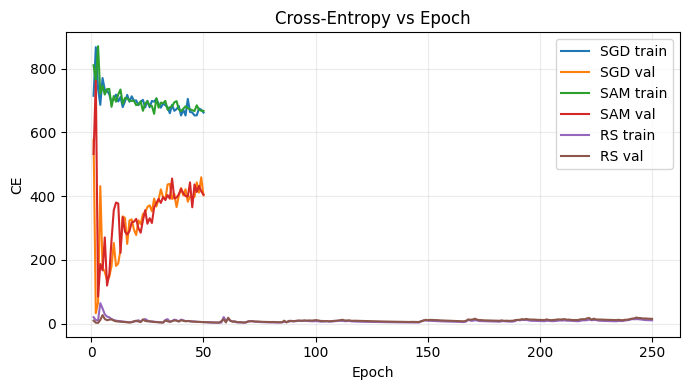

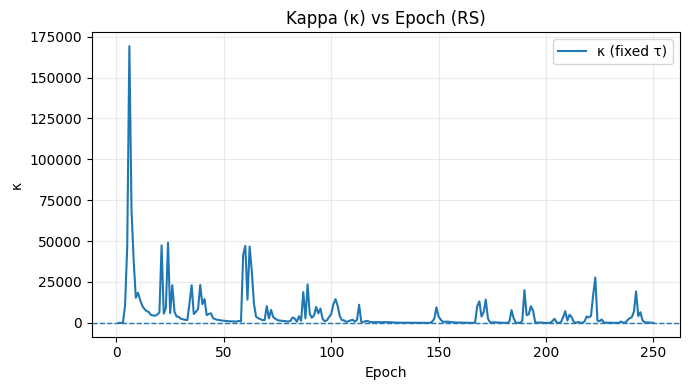

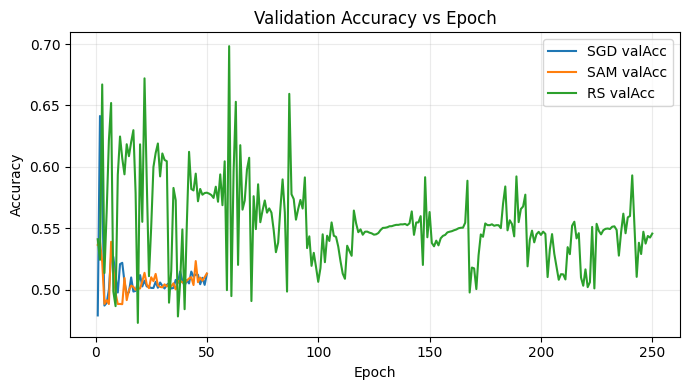

In [11]:
# --- Cell 9: Plots: train vs validation CE for each algorithm ---
epochs_rs  = list(range(1, len(ce_tr_rs)+1))
epochs_sgd = list(range(1, len(tr_sgd)+1))
epochs_sam = list(range(1, len(tr_sam)+1))

plt.figure(figsize=(7,4))
plt.plot(epochs_sgd, tr_sgd, label="SGD train")
plt.plot(epochs_sgd, val_sgd, label="SGD val")
plt.plot(epochs_sam, tr_sam, label="SAM train")
plt.plot(epochs_sam, val_sam, label="SAM val")
plt.plot(epochs_rs,  ce_tr_rs, label="RS train")
plt.plot(epochs_rs,  ce_val_rs, label="RS val")
plt.title("Cross-Entropy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("CE")
plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout()
plt.show()

# --- NEW: plot κ over epochs for RS (τ fixed) ---
plt.figure(figsize=(7,4))
plt.plot(epochs_rs, kappa_hist, label="κ (fixed τ)")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("Kappa (κ) vs Epoch (RS)")
plt.xlabel("Epoch"); plt.ylabel("κ")
plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout()
plt.show()

# Optional: plot validation accuracy to see generalization directly
plt.figure(figsize=(7,4))
plt.plot(epochs_sgd, acc_sgd, label="SGD valAcc")
plt.plot(epochs_sam, acc_sam, label="SAM valAcc")
plt.plot(epochs_rs,  acc_val_rs, label="RS valAcc")
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout()
plt.show()

In [12]:
# Cell 10 ▸ Save models to Google Drive (optional)
save_dir = "/content/drive/My Drive/camelyon17_checkpoints"
os.makedirs(save_dir, exist_ok=True)
torch.save(model_sgd.state_dict(), f"{save_dir}/sgd.pth")
torch.save(model_rs.state_dict(),  f"{save_dir}/rs.pth")
torch.save(model_sam.state_dict(), f"{save_dir}/sam.pth")
print("✔️  Models saved to", save_dir)


✔️  Models saved to /content/drive/My Drive/camelyon17_checkpoints


In [13]:
# Cell 11: disconnect from runtime
from google.colab import runtime
runtime.unassign()